### Training

In [178]:
from diffmd.solvers import odeint_adjoint
from diffmd.utils import compute_grad
from diffmd.utils import body_to_lab_frame, lab_to_body_frame, quat_to_euler_angles


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import shutil
# TODO: fix quaternion module warning because of NUMBA
import quaternion
from torchviz import make_dot # visualize computation graphs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f'Using {device} device')

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)

def get_first_batch(trajs,nsample,sampleLength,dt):
    twice_dim = trajs.size()[2]
    dim = twice_dim//2
    
    q0 = trajs[0:nsample, 0, :dim].to(device)
    p0 = trajs[0:nsample, 0, dim:].to(device)
    batch_y0 = (p0, q0)
    
    q = trajs[0:nsample, 0:sampleLength, :dim].to(device)
    p = trajs[0:nsample, 0:sampleLength, dim:].to(device)
    batch_y = torch.cat((p, q), dim=2).swapaxes(0, 1)
    
    batch_t = torch.linspace(0.0,dt*(sampleLength-1),sampleLength).to(device)
    return batch_t, batch_y0, batch_y

class ODEFunc(nn.Module):
    def __init__(self, nparticles, inertia, dim, width, depth):
        super(ODEFunc, self).__init__()
        self.dim = dim
        self.nparticles = nparticles
        layers = []
        for i in range(depth):
            if i == 0:
                # first layer takes in all configurational variables (xyz and quaternions)
                layers += [nn.Linear(self.dim, width), nn.Sigmoid()]
            if i == (depth-1):
                # last layer outputs a single potential energy value
                layers += [nn.Linear(width, 1)]
            else:
                layers += [nn.Linear(width, width), nn.Sigmoid()]
        self.net = nn.Sequential(*layers).type(torch.float64)
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)

        # HACK
        self.mass = 7.0
        self.inertia = inertia

    def forward(self, state):

        with torch.set_grad_enabled(True):    
            # TODO: make sure batching and dimensions are sent appropriately
            v = state[0]
            # print(v.requires_grad)
            w = state[1]
            x = state[2] # [number of bodies, number of trajectories, number of dimensions]
            q = state[3]
            
            x.requires_grad = True
            q.requires_grad = True
            
            # normalise quaternions to unit length
            q = q / torch.norm(q, dim=2).unsqueeze(2)
            assert torch.norm(q, dim=2).max() < 1.001, 'quaternions not normalised'
            
            # TODO: is this the corect way to get euler angles? is the correct implementation in terms of the cosine and sine formula?
            # TODO: test out different conventions of how to interpret quaternions
            # TODO: write simple unit tests to check we are truly using the correct convention
            theta = quat_to_euler_angles(q)
            xtheta = torch.cat((x, theta), dim=2).view(-1, x.shape[1])
            
            # TODO: add a method inside ODEFunc that subtracts the harmonic restraing from the potential energy
            u = self.net(xtheta.T) # [potential energy, number of trajectories]
            
            fT = -compute_grad(inputs=xtheta, output=u.T) # [force _ torque, number of trajectories]
            # HACK: make sure we are splitting based on number of coordinates
            f, T = torch.split(fT, [self.nparticles * 3, self.nparticles * 3], dim=0) # capital T means in lab coordinates
            f = f.view(self.nparticles, -1, 3)
            T = T.view(self.nparticles, -1, 3)
            # translation motion
            dvdt = f / self.mass
            dxdt = v
            # rotational motion
            q_conj = torch.cat((q[:, :, 0:1], -q[:, :, 1:]), dim=2) # get conguarient quaternions
            dLdt = torch.cat((torch.zeros(T.shape[0], T.shape[1], 1).to(device), T), dim=2) # [number of bodies, number of trajectories, 4]
            dldt = q * dLdt * q_conj
            dwdt = dldt[:, :, 1:] / self.inertia[:, None, :]
            dqdt = (0.5 * body_to_lab_frame(w) @ q[:, :, :, None]).squeeze()
            assert torch.all(dqdt[0, 0, :] == (0.5 * body_to_lab_frame(w)[0, 0, :, :] @ q[0, 0, :, None]).squeeze()), 'dqdt tensor update is incorrect'

        return (dvdt, dwdt, dxdt, dqdt)

    # def compute_grad(self, q, dq):
    #     # using this over compute_grad from nff seems to make no difference
    #     # HACK: does this only work with q_n => n=1? 
    #     return (self.net(q+dq) - self.net(q-dq)) / (2 * dq)

def get_data():
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]', 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    inertia = ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]', 'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    # inertia = df.loc[0, ['timestep', *inertia]]
    inertia = df.loc[:, ['timestep', *inertia]]
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia

def process_inertia(inertia):
    assert np.all(inertia.std().iloc[1:].to_numpy() == 0), 'inertia is not constant'
    inertia = inertia.iloc[0, 1:].to_numpy().reshape(2, 3)
    return torch.from_numpy(inertia).to(device)

def process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia):
    # HACK: send a single trajectory
    ntraj = 1

    # HACK: pair potential
    nparticles = 2
    vel_dim = 3
    angvel_dim = 3
    com_dim = 3
    quat_dim = 4

    # Get centre of masses
    com1 = centre_of_masses.loc[:, ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]']].to_numpy()
    com2 = centre_of_masses.loc[:, ['c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']].to_numpy()
    # separation = np.linalg.norm(com1-com2, axis=1).reshape(-1, 1)
    coms = torch.from_numpy(np.hstack((com1, com2))).to(device).view(ntraj, -1, nparticles, com_dim)
    
    # Get quaternion rotations
    quat1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
    quat2 = quaternions.loc[:, ['c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', "c_q_2[4]"]].to_numpy()
    quats = torch.from_numpy(np.hstack((quat1, quat2))).to(device).view(ntraj, -1, nparticles, quat_dim)
    
    # Get translation velocities
    vel1 = velocities.loc[:, ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]']].to_numpy()
    vel2 = velocities.loc[:, ['c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]']].to_numpy() 
    # hexagon_mass = 7.0
    # mom = torch.from_numpy(np.hstack((vel1 * hexagon_mass, vel2 * hexagon_mass))).to(device).view(ntraj, -1, nparticles, vel_dim)
    vel = torch.from_numpy(np.hstack((vel1, vel2))).to(device).view(ntraj, -1, nparticles, vel_dim)

    # Get angular velocities
    ang_mom = torch.from_numpy(ang_momenta.iloc[:, 1:].to_numpy()).to(device).view(ntraj, -1, nparticles, angvel_dim)
    ang_vel = ang_mom / inertia.view(ntraj, -1, nparticles, angvel_dim)
    return (vel, ang_vel, coms, quats)



Using cuda device


Iter: 10, running avg elbo: 0.5419
current loss: 0.5448
Last iteration took:  0.5398271139711142
Iter: 20, running avg elbo: 0.5422
current loss: 0.5465
Last iteration took:  0.5535592194646597
Iter: 30, running avg elbo: 0.5423
current loss: 0.5426
Last iteration took:  0.546837292611599
Iter: 40, running avg elbo: 0.5425
current loss: 0.5476
Last iteration took:  0.5461164806038141
Iter: 50, running avg elbo: 0.5425
current loss: 0.5437
Last iteration took:  0.5466147996485233
Iter: 60, running avg elbo: 0.5427
current loss: 0.5432
Last iteration took:  0.5461107734590769
Iter: 70, running avg elbo: 0.5429
current loss: 0.5480
Last iteration took:  0.5497934836894274
Iter: 80, running avg elbo: 0.5429
current loss: 0.5464
Last iteration took:  0.5483070835471153
Iter: 90, running avg elbo: 0.5431
current loss: 0.5421
Last iteration took:  0.5466783791780472


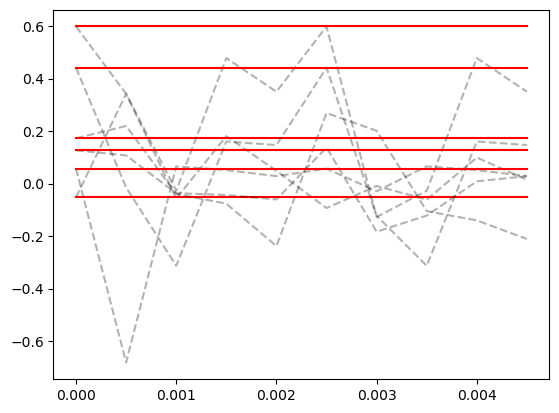

Iter: 100, running avg elbo: 0.5431
current loss: 0.5383
Last iteration took:  0.7494824547320604
Iter: 110, running avg elbo: 0.5433
current loss: 0.5452
Last iteration took:  0.5530154686421156
Iter: 120, running avg elbo: 0.5434
current loss: 0.5457
Last iteration took:  0.5463542509824038
Iter: 130, running avg elbo: 0.5434
current loss: 0.5373
Last iteration took:  0.5458945091813803


In [185]:
from diffmd.solvers import odeint_adjoint

prefix = 'hexagons/trajectories/dump_2303/'
file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

def get_batch_mod(traj, batch_size, batch_length, dt):
    # TODO: change everything from ANGULAR VELOCITY to ANGULAR MOMENTUM
    """
    Get a batch of data from a trajectory.
        
    Args:
        traj (tuple): torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions)
        batch_size (int): number of trajectories in the batch
        batch_length (int): length of each trajectory in the batch
        dt (float): time step
    
    Returns:
        batch_t (torch.Tensor): time steps for the batch
        pos_init (torch.Tensor): initial positions for the batch
        batch_trajs (tuple): batch of torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions - in the form (nparticles, batch_size, batch_length, dim))
    """
    nparticles = trajectory[0].shape[2]
    vel_dim = trajectory[0].size()[3]
    angvel_dim = trajectory[1].size()[3]
    com_dim = trajectory[2].size()[3]
    quat_dim = trajectory[3].size()[3]

    assert vel_dim == 3, 'velocity dimension must be 3'
    assert angvel_dim == 3, 'angular velocity dimension must be 3'
    assert com_dim == 3, 'centre of mass dimension must be 3'
    assert quat_dim == 4, 'quaternion dimension must be 4'

    sampled_is = torch.randint(traj[0].shape[0],size = (batch_size,)).to(device)
    sampled_js = torch.randint(traj[0].shape[1]-batch_length,size = (batch_size,)).to(device)
    initial_time = sampled_js*dt
    
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
    
    vels = traj[0][sampled_is,sampled_js,:,:].view(nparticles, batch_size, vel_dim)
    ang_vels = traj[1][sampled_is,sampled_js,:,:].view(nparticles, batch_size, angvel_dim)
    coms = traj[2][sampled_is,sampled_js,:,:].view(nparticles, batch_size, com_dim)
    quats = traj[3][sampled_is,sampled_js,:,:].view(nparticles, batch_size, quat_dim)
    
    pos_init = (vels, ang_vels, coms, quats)

    sampled_vels = []
    sampled_ang_vels = []
    sampled_coms = []
    sampled_quats = []
    for i in range(batch_size):
        vels = traj[0][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].reshape(nparticles, batch_length, vel_dim)
        ang_vels = traj[1][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].reshape(nparticles, batch_length, angvel_dim)
        coms = traj[2][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].reshape(nparticles, batch_length, com_dim)
        quats = traj[3][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].reshape(nparticles, batch_length, quat_dim)
        # x = torch.cat((vels, ang_vels, coms, quats), dim=1)
        # sampled_trajs.append(x)
        sampled_vels.append(vels)
        sampled_ang_vels.append(ang_vels)
        sampled_coms.append(coms)
        sampled_quats.append(quats)
        
    sampled_vels = torch.stack(sampled_vels, dim=1).type(torch.float64)
    sampled_ang_vels = torch.stack(sampled_ang_vels, dim=1).type(torch.float64)
    sampled_coms = torch.stack(sampled_coms, dim=1).type(torch.float64)
    sampled_quats = torch.stack(sampled_quats, dim=1).type(torch.float64)
    batch_trajs = (sampled_vels, sampled_ang_vels, sampled_coms, sampled_quats)
    return batch_t, pos_init, batch_trajs



niters = 1000
nn_width = 25
nn_depth = 2
learning_rate = 1e-1
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 400
batch_length = 10

loss_meter = RunningAverageMeter()
# dim = nparticles * ((trajectory[2].size()[-1]) + (trajectory[3].size()[-1])) # add number of quaternions and centre of masses degrees of freedom
dim = nparticles * (3 + 3)
func = ODEFunc(nparticles, inertia, dim, nn_width, nn_depth).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()
    
    # HACK: to try sending in a trajectory
    batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, 0.0005)
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    pred_y = torch.cat(pred_y, dim=-1)
    batch_y = torch.cat(batch_y, dim=-1).view(pred_y.shape)
    
    make_dot(pred_y, params=dict(func.named_parameters()), show_attrs=True, show_saved=True).render("temp/torchviz", format="png")

    # TODO: train only on specifics and not all of the data
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 100 == 0:
        with torch.no_grad():
            for i in range(6):
                plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', label=f'pred {i}')
            plt.show()

    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)


In [95]:
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

In [ ]:
print(trajectory)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01518218, -0.0139471 ,  0.01710846, ..., -0.0215073 ,
        -0.0290482 , -0.00088951],
       [-0.02682069,  0.0195529 , -0.06787774, ..., -0.173707  ,
        -0.0441775 , -0.0367169 ],
       ...,
       [-0.0213354 ,  0.277402  , -0.0801334 , ...,  0.099064  ,
         0.111093  ,  0.0802596 ],
       [-0.0109809 ,  0.315444  , -0.1316132 , ...,  0.0687512 ,
         0.115968  ,  0.0391946 ],
       [ 0.0974403 ,  0.292485  , -0.0782197 , ...,  0.00388676,
         0.0939857 , -0.0465734 ]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.44322943e+00,  9.99824108e-01, -4.29189831e-03,
        -1.81224667e-02, -2.07064793e-03],
       [ 2.42378183e+00,  9.99116925e-01, -4.32879377e-03,
        -3.99009689e-02,  1.23820525e-02],
       ...,
       [ 6.38621611e+00, -7.11082596e-01,  4.32012695e-01,
        

    index  timestep  body_id    id         x         y         z
0      28    1000.0      1.0   1.0  0.989920  0.005859 -0.020850
1      29    1000.0      1.0   2.0  0.495232  0.874905 -0.014301
2      30    1000.0      1.0   3.0 -0.504460  0.881011  0.009731
3      31    1000.0      1.0   4.0 -1.009460  0.018072  0.027215
4      32    1000.0      1.0   5.0 -0.514776 -0.850974  0.020666
5      33    1000.0      1.0   6.0  0.484916 -0.857080 -0.003366
6      34    1000.0      1.0   7.0 -0.009772  0.011965  0.003183
7      35    1000.0      2.0   8.0  2.005380  1.006250  2.004160
8      36    1000.0      2.0   9.0  1.503160  1.870960  1.996230
9      37    1000.0      2.0  10.0  0.503239  1.868330  1.984050
10     38    1000.0      2.0  11.0  0.005532  1.000990  1.979800
11     39    1000.0      2.0  12.0  0.507748  0.136286  1.987730
12     40    1000.0      2.0  13.0  1.507670  0.138914  1.999910
13     41    1000.0      2.0  14.0  1.005450  1.003620  1.991980
          x         y
0  

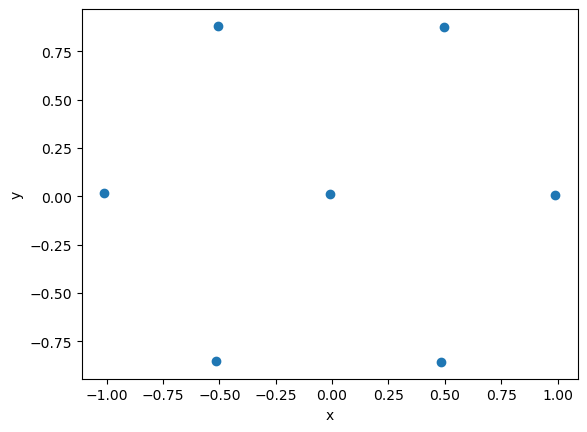

In [ ]:
firstStep = orig_traj.loc[orig_traj['timestep'] == 1000].reset_index()
firstHexagon = firstStep.loc[:6, ['x', 'y']]
print(firstStep)
print(firstHexagon)
plt.plot(firstHexagon.iloc[:, 0], firstHexagon.iloc[:, 1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
ang_vel_1 = ang_velocities.iloc[:, 0:3].to_numpy()
ang_mom_1 = ang_momenta.iloc[:, 0:3].to_numpy()
# print(ang_vel_1)
# print(ang_mom_1)

inertia_1 = ang_mom_1[1:, :] / ang_vel_1[1:, :]
# for i in range(100):
    # print(inertia_1[i])

# quaternion vectors are normalised
# print(np.linalg.norm(quat1[:, 1:], axis=1))



# quaternion package
# print(quat1.shape)
quat1 = quaternion.as_quat_array(quat1)
# print(quat1[0])
# print(quaternion.as_rotation_matrix(quat1)[0])
q = quat1[0]
R = quaternion.as_rotation_matrix(quat1)[0]
# print(q)
vector1 = np.array([2.5, 3.6, 3.7])
vector1_Q = np.quaternion(0, 2.5, 3.6, 3.7)
vector2_R = R @ vector1
vector2_Q = q * vector1_Q * q.conjugate()


# print(q)
# print(q.conjugate())
# print(R.shape)

print(vector2_Q)
print(quaternion.as_float_array(vector2_Q))


vector_plot([vector1, vector2_R, quaternion.as_float_array(vector2_Q)[1:]])




quaternion(6.93889390390723e-18, -2.38796216413147, -3.63768324282903, 3.73695904748035)
[ 6.93889390e-18 -2.38796216e+00 -3.63768324e+00  3.73695905e+00]


In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
quats = quaternion.as_quat_array(quat1[:10])
# consider quaternions to be a rotation from x axis
vector = np.quaternion(0, 1, 0, 0)
print(vector)
vector = quats * vector * quats.conjugate()

# print(quats)
# print(quats.conjugate())
vectors = quaternion.as_float_array(vector)[:, 1:]
# plots subsequent orientations
vector_plot(list(vectors))
print(list(vectors))

quaternion(0, 1, 0, 0)


[array([-0.99969073, -0.00631347,  0.0240322 ]), array([-0.99908286,  0.00160399,  0.04277968]), array([-0.99706856,  0.02358701,  0.07279627]), array([-0.99604604,  0.03336901,  0.08234398]), array([-0.99751062,  0.04460248,  0.05461585]), array([-0.99677454,  0.07958029,  0.01032569]), array([-0.99301676,  0.11074407, -0.04067183]), array([-0.99175207,  0.09744422, -0.08325662]), array([-0.99261598,  0.07128534, -0.09814727]), array([-0.99204744,  0.09161861, -0.08629929])]


In [ ]:
def get_batch_mod(traj,batch_size,batch_length,dt):

  twice_dim = traj.size()[2]
  dim = twice_dim//2
  sampled_is = torch.randint(traj.shape[0],size = (batch_size,)).to(device)
  sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,)).to(device)
  initial_time = sampled_js*dt

  batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
  qs = traj[sampled_is,sampled_js,:dim]
  ps = traj[sampled_is,sampled_js,dim:]
  pos_init = (ps, qs)
  # print('p', ps)
  # print('q', qs)

  sampled_trajs = []

  for i in range(batch_size):
      qs = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:dim].view(-1,dim)
      ps = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,dim:].view(-1,dim)
      x = torch.cat((ps, qs), dim=1)
      sampled_trajs.append(x)

      
  batch_trajs = torch.stack(sampled_trajs,dim=1)
  return batch_t,pos_init,batch_trajs
     

def get_data():
    train_split = 0.9
    test_split = 1 - train_split
    trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    split_index = int(trajs.shape[0] * train_split)

    np.random.shuffle(trajs)
    training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return training_trajs, testing_trajs 

def train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width):    
    loss_meter = RunningAverageMeter()
    dim = training_trajs.size()[2] // 2
    func = ODEFunc(dim, nn_width, nn_depth).to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

    for itr in range(1, niters + 1):
        start = time.perf_counter()
        optimizer.zero_grad()
        
        batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, batch_size, sample_length,dt)
        
        # convert momentum to velocity (v = p / mu)
        batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
        pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

        # convert velocity to momentum (p = mu * v)
        pred_y = (pred_y[0] * func.mass, pred_y[1])
        pred_y = torch.cat(pred_y, dim=2)
        
        loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
        loss.backward() 
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % 10 == 0: # output log throughout
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
            print('current loss: {:.4f}'.format(loss_meter.val))
            print('Last iteration took: ', time.perf_counter() - start)

    return func, loss_meter

def test_model(func, testing_trajs, dt):    
    loss_meter = RunningAverageMeter()
    batch_size = testing_trajs.shape[0]
    sample_length = testing_trajs.shape[1]
    batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length, dt)
        
    # convert momentum to velocity (v = p / mu)
    batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    # convert velocity to momentum (p = mu * v)
    pred_y = (pred_y[0] * func.mass, pred_y[1])
    pred_y = torch.cat(pred_y, dim=2)
    
    loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
    loss_meter.update(loss.item())
    
    return loss_meter

def evaluate_model(sample_length, batch_size, learning_rate, nn_depth, nn_width, activation_function):
    niters = 300
    dt = 0.1
    t0 = time.perf_counter()

    training_trajs, testing_trajs = get_data()
    model, train_loss = train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width)
    training_time = time.perf_counter() - t0

    test_loss = test_model(model, testing_trajs, dt)

    training_and_testing_time = time.perf_counter() - t0
    return train_loss, test_loss, training_time, training_and_testing_time


import sigopt

def run_and_track_in_sigopt():

#   sigopt.log_dataset(DATASET_NAME)
#   sigopt.log_metadata(key="Dataset Source", value=DATASET_SRC)
#   sigopt.log_metadata(key="Feature Eng Pipeline Name", value=FEATURE_ENG_PIPELINE_NAME)
#   sigopt.log_metadata(
#     key="Dataset Rows", value=features.shape[0]
#   )  # assumes features X are like a numpy array with shape
#   sigopt.log_metadata(key="Dataset Columns", value=features.shape[1])
#   sigopt.log_metadata(key="Execution Environment", value="Colab Notebook")
  sigopt.log_model('Neural ODE Simple Harmonic Motion')
  learning_rates = [10**i for i in range(-5, 1)]
  sigopt.params.setdefaults(
    sample_length=np.random.randint(low=3, high=50),
    batch_size=np.random.randint(low=10, high=1000),
    learning_rate=np.random.choice(learning_rates),
    nn_depth=np.random.randint(low=1, high=5),
    nn_width=np.random.randint(low=2, high=50),
    # activation_function=,  
  )

  args = dict(
    sample_length=sigopt.params.sample_length,
    batch_size=sigopt.params.batch_size,
    learning_rate=sigopt.params.learning_rate,
    nn_depth=sigopt.params.nn_depth,
    nn_width=sigopt.params.nn_width,
    activation_function=None,
  )

  train_loss, test_loss, training_time, training_and_validation_time = evaluate_model(**args)

  running_avg_train_loss = train_loss.avg
  running_avg_test_loss = test_loss.avg

  sigopt.log_metric(name="train_loss", value=running_avg_train_loss)
  sigopt.log_metric(name="test_loss", value=running_avg_test_loss)
  sigopt.log_metric(name="training time (s)", value=training_time)
  sigopt.log_metric(name="training and validation time (s)", value=training_and_validation_time)

run_and_track_in_sigopt()

In [ ]:
import matplotlib.pyplot as plt
prefix = 'hexagons/trajectories/dump_2303/'
file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'
# prefix = 'hexagons/trajectories/inertia_issue/'
# file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'
end_index = 100

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

quat_1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
# ang_vel_1 = ang_velocities.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]']].to_numpy()
ang_mom_1 = ang_momenta.loc[:, ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]']].to_numpy()
ang_mom_2 = ang_momenta.loc[:, ['c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']].to_numpy()
inertia_1 = inertia.loc[0, ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]']].to_numpy()
inertia_2 = inertia.loc[0, ['c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']].to_numpy()
# print(inertia_1)
# print(inertia_2)
# print(ang_mom_1)
# print(ang_mom_1**2 / 2 * inertia_1)
E_k_1 = np.sum(ang_mom_1**2 / 2 * inertia_1, axis=1) 
E_k_2 = np.sum(ang_mom_2**2 / 2 * inertia_2, axis=1)

# Plot energy
plt.plot(E_k_1[:end_index], label='E_k_1')
plt.plot(E_k_2[:end_index], label='E_k_2')
plt.legend()
plt.show()


# # Plot each column of inertia_1 as a separate line
plt.plot(ang_mom_1[:end_index, 0], 'r', label='angmom_x')
plt.plot(ang_mom_1[:end_index, 1], 'g', label='angmom_y')
plt.plot(ang_mom_1[:end_index, 2], 'b', label='angmom_z')
plt.legend()
plt.show()